# Gaussian Process Regression

## Theoretic Foundation

 The goal of previously introduced methods was to find a distribution over the weights of a parameterized function i.e. a neural network. In contrast, the basic idea of a Gaussian Process (GP) is to instead consider a distribution over possible functions, that fit the data in some way. Formally,

*"A Gaussian process is a collection of random variables, any finite number of which have a joint Gaussian distribution."* [Seeger, 2004](https://www.worldscientific.com/doi/abs/10.1142/S0129065704001899)

Precisely, a GP can be described by a possibly infinite amount of function values
$$
    f(x) \sim \mathcal{GP}(m(x),k_{\gamma}(x)),
$$

such that any finite collection of function values $f$ has a joint Gaussian
distribution,

$$
 f = f(X) = [f(x_1),\dots,f(x_K)]^{\top} \sim \mathcal{N}(m_X,\mathcal{K}_{X,X}),
$$

with a mean vector, $(m_X)i = m(x_i)$, and covariance matrix, $(\mathcal{K}_{X,X})_{ij} = k_{\gamma}(x_i,x_j)$, 
stemming from the mean function $m$ and covariance kernel of the GP, $k_{\gamma}$, that is parametrized by $\gamma$. A commonly used covariance function is the squared exponential, also referred to as Radial Basis Function (RBF) kernel, exponentiated quadratic or Gaussian kernel:

$$
    k_{\gamma}(x,x') = \text{cov}(f(x),f(x')) = \eta^2\exp{\left(-\frac{1}{2l^2}|x-x'|^2\right)}.
$$

Where $\gamma =( \eta^2, l)$ and $\eta^2$ can be set to $1$ or tuned as a hyperparameter. By default the lengthscale $l=1$ but can also be optimized over. Now the GP, $f (x) \sim GP(m(x), k(x, x'))$, as a distribution over functions can be used to solve a regression problem. Following [Seeger, 2004](https://www.worldscientific.com/doi/abs/10.1142/S0129065704001899), consider the simple special case where the observations are noise free and you have training data $\mathcal{D}_{\mathrm{train}} = \{(x_i, y_i)\}_{i=1}^{K}$ with $X=(x_i)_{i=1}^K$ and $Y=(y_i)_{i=1}^K$. The joint prior distribution of the training outputs, $Y$, and the test outputs $f_*=f_*(X_*)= (f(x_k))_{k=1}^m$ where $X_* = (x_k)_{k=1}^m$ are the test points, according to the prior is

\begin{align*}
 p(Y,f_*) = \mathcal{N}\bigg(0, \Bigg[ \begin{array}{rr}
\mathcal{K}_{X,X} & \mathcal{K}_{X,X_*}  \\
\mathcal{K}_{X_*,X} & \mathcal{K}_{X_*,X_*}  \\
\end{array} \Bigg] \bigg).
\end{align*}

Here the mean function is assumed to be $m_X = 0$ and $\mathcal{K}_{X,X_*}$ denotes the $K \times m$ matrix of the covariances evaluated at all pairs of training and test
points, and similarly for the other entries $\mathcal{K}_{X,X}$, $\mathcal{K}_{X_*,X_*}$ and $\mathcal{K}_{X_*,X}$. To make predictions based on the knowledge of the training points, conditioning on the prior observations is used and yields,

\begin{align*}
    p(f_*|X_*, X, Y) & = \mathcal{N}(\mathcal{K}_{X_*,X}\mathcal{K}_{X,X}^{-1}Y, \mathcal{K}_{X_*,X_*}-\mathcal{K}_{X_*,X_*}\mathcal{K}_{X,X}^{-1}\mathcal{K}_{X,X_*})\\
    & = \mathcal{N}(m(X,X_*,Y), \tilde{\mathcal{K}}_{X,X_*}).
\end{align*}
  
Now to generate function values on test points, one uses samples from the posterior distribution $f_*(X_*) \sim \mathcal{N}(m(X,X_*,Y), \tilde{K}(X, X_*))$.  To illustrate how we can obtain these samples from the posterior distribution, consider a Gaussian with arbitrary mean $m$ and covariance $K$, i.e. $f_* \sim \mathcal{N}(m,K)$. For this one can use a scalar Gaussian generator, which is available in many packages:

- Compute the Cholesky decomposition of $K=LL^T$, where $L$ is a lower triangular matrix. This works because $K$ is symmetric by definition.
- Then, draw multiple $u \sim \mathcal{N}(0, I)$.
- Now, compute the samples with $f_* = m + Lu$. This has the desired mean, $m$ and covariance $L\mathbb{E}(uu^T)L^T = LL^T = K$.


The above can be extended to incorporate noisy measurements $y \rightarrow y + e$, see [Seeger, 2004](https://www.worldscientific.com/doi/abs/10.1142/S0129065704001899), or noise on the inputs as in [Johnson, 2019](https://ieeexplore.ieee.org/abstract/document/8746634). Both of these extensions require tuning of further hyperparameters, yet beneficially allow to incorporate a prediction of aleatoric uncertainty in a GP.

For example, assume additive Gaussian noise on the distribution of the function values, 

$$
    p(y(x)|f(x)) =  \mathcal{N}(y(x); f(x),\sigma^2).
$$

Then the predictive distribution of the GP evaluated at the
$K_*$ test points, $X_*$, is given by
\begin{align*}
 p(f_*|X_*,X,Y,\gamma,\sigma^2) &= \mathcal{N}(\mathbb{E}[f_*],\text{cov}(f_*)), \\
 \mathbb{E}[f_*] &= m_{X_*}  + \mathcal{K}_{X_*,X}[\mathcal{K}_{X,X}+\sigma^2 I]^{-1}Y,\\
 \text{cov}(f_*) &= \mathcal{K}_{X_*,X_*} - \mathcal{K}_{X_*,X}[\mathcal{K}_{X,X}+\sigma^2 I]^{-1}\mathcal{K}_{X,X_*}.
\end{align*}
Here $m_{X_*}$ is the $K_* \times 1$ mean vector, which is assumed to be zero in the previous case.

In both cases, with and without additive noise on the function values, the GP is trained by learning interpretable kernel hyperparameters. The log marginal likelihood of the targets $y$ - the probability of the data conditioned only on kernel hyperparameters $\gamma$ - provides a principled probabilistic framework for kernel learning:
$$
 \log p(y | \gamma, X) \propto -\left(y^{\top}(\mathcal{K}_{\gamma}+\sigma^2 I)^{-1}y + \log|\mathcal{K}_{\gamma} + \sigma^2 I|\right),
$$
where $\mathcal{K}_{\gamma}$ is used for $\mathcal{K}_{X,X}$ given $\gamma$. Kernel learning can be achieved by optimizing the above with respect to $\gamma$.

The computational bottleneck for inference is solving the linear system
$(\mathcal{K}_{X,X}+\sigma^2 I)^{-1}y$, and for kernel learning it is computing
the log determinant $\log|\mathcal{K}_{X,X}+ \sigma^2 I|$ in the marginal likelihood.  
The standard approach is to compute the Cholesky decomposition of the
$K \times K$ matrix $\mathcal{K}_{X,X}$, which
requires $\mathcal{O}(K^3)$ operations and $\mathcal{O}(K^2)$ storage.
After inference is complete, the predictive mean costs $\mathcal{O}(K)$,
and the predictive variance costs $\mathcal{O}(K^2)$, per test point
$x_*$.

## Imports

In [1]:
import os
import sys

# required to make the path visible to import the tools
# this will change in public notebooks to be "pip install uq-regression-box"
nb_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
nb_dir

import tempfile

import numpy as np
import gpytorch
import matplotlib.pyplot as plt
import torch
from lightning.pytorch import seed_everything
from tqdm import trange

from lightning_uq_box.datamodules import ToyHeteroscedasticDatamodule
from lightning_uq_box.viz_utils import (
    plot_calibration_uq_toolbox,
    plot_predictions_regression,
    plot_toy_regression_data,
)

plt.rcParams["figure.figsize"] = [14, 5]

In [2]:
seed_everything(0)  # seed everything for reproducibility

Seed set to 0


0

We define a temporary directory to look at some training metrics and results.

In [3]:
my_temp_dir = tempfile.mkdtemp()

## Datamodule

To demonstrate the method, we will make use of a Toy Regression Example that is defined as a [Lightning Datamodule](https://lightning.ai/docs/pytorch/stable/data/datamodule.html). While this might seem like overkill for a small toy problem, we think it is more helpful how the individual pieces of the library fit together so you can train models on more complex tasks.

In [4]:
dm = ToyHeteroscedasticDatamodule()

X_train, y_train, train_loader, X_test, y_test, test_loader = (
    dm.X_train,
    dm.y_train,
    dm.train_dataloader(),
    dm.X_test,
    dm.y_test,
    dm.test_dataloader(),
)

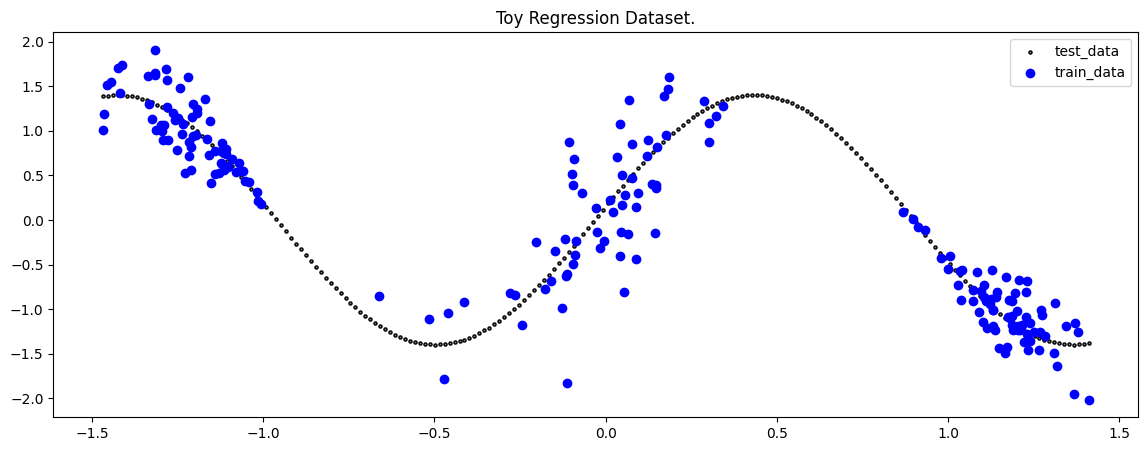

In [5]:
plot_toy_regression_data(X_train, y_train, X_test, y_test)

## Model

In [6]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [7]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()

# init with batch from
gp_model = ExactGPModel(X_train.squeeze(), y_train.squeeze(), likelihood)

# Find optimal model hyperparameters
gp_model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(
    gp_model.parameters(), lr=1e-2
)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, gp_model)

bar = trange(100)
for i in bar:
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = gp_model(X_train.squeeze())
    # Calc loss and backprop gradients
    loss = -mll(output, y_train.squeeze())
    loss.backward()
    optimizer.step()
    bar.set_postfix(loss=f"{loss.detach().cpu().item()}")

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:11<00:00,  8.39it/s, loss=0.6156280636787415]


## Prediction

In [8]:
gp_model.eval()
likelihood.eval()

with torch.no_grad():
    gp_preds = gp_model(X_test.cpu())

gp_mean = gp_preds.mean.detach().cpu().numpy()
gp_var = gp_preds.variance.detach().cpu().numpy()
gp_covar = gp_preds.covariance_matrix.detach().cpu().numpy()

## Evaluate Predictions

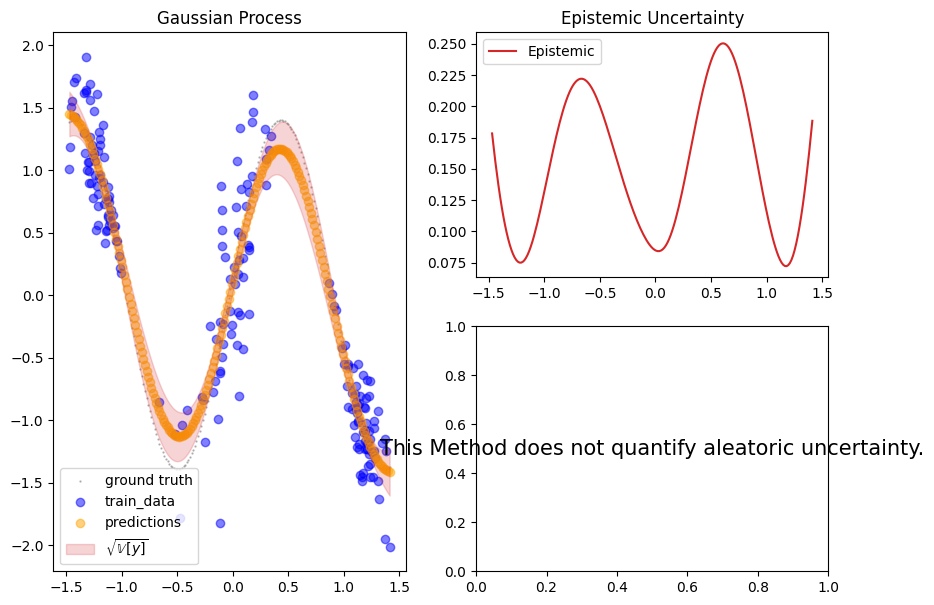

In [9]:
fig = plot_predictions_regression(
    X_train,
    y_train,
    X_test,
    y_test,
    gp_mean[:, None],
    np.sqrt(gp_var),
    epistemic=np.sqrt(gp_var),
    title="Gaussian Process",
    show_bands=False,
)

For some additional metrics relevant to UQ, we can use the great [uncertainty-toolbox](https://uncertainty-toolbox.github.io/) that gives us some insight into the calibration of our prediction. For a discussion of why this is important, see ...

<Figure size 1400x500 with 0 Axes>

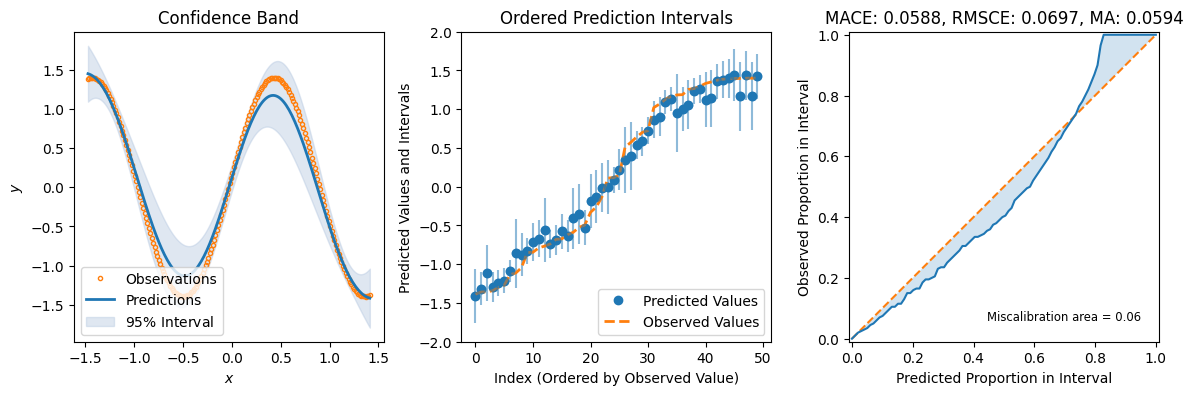

In [10]:
fig = plot_calibration_uq_toolbox(
    gp_mean, np.sqrt(gp_var), y_test.cpu().numpy(), X_test.cpu().numpy()
)